## Import packages and set environment variables

In [ ]:
import os
os.environ["R_HOME"] = "/home/michael/anaconda3/envs/torch/lib/R"
import numpy as np
import src as ddfa_node
import matplotlib.pyplot as plt
import importlib
import torch
importlib.reload(ddfa_node)
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%matplotlib inline

## Load and prepare data

In [3]:
data_path = "/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy"
data = ddfa_node.load_data_normalize(6, '/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy')

## Taken's Embed the data with optimal parameters

In [4]:
# time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=500)
τ, k = 19, 9
time_delayed_data = ddfa_node.takens_embedding(data, τ, k)

## Train models

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train/test splitting
train_size = 0.8
data_train, data_val = ddfa_node.split_data(time_delayed_data, train_size=train_size)

# Subsample whole trials to smaller ones
timesteps_per_sample = 150
data_train, data_val = ddfa_node.change_trial_length(data_train, timesteps_per_subsample=timesteps_per_sample), change_trial_length(data_val, timesteps_per_subsample=timesteps_per_sample)

# Add noise to data
noise_std = 0.05
data_train = ddfa_node.augment_data_with_noise(data_train, n_copies=5, noise_std=noise_std)

data_train, data_val = torch.from_numpy(data_train).float().to(device), torch.from_numpy(data_val).float().to(device)

ts_num = 4.5
tot_num = data_train.shape[1]

samp_ts = np.linspace(0, ts_num, num=tot_num)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

val_num = ts_num / tot_num * data_val.shape[1]
val_ts = np.linspace(0, val_num, data_val.shape[1])
val_ts = torch.from_numpy(val_ts).float().to(device)

In [ ]:
batch_size = 32
latent_dim = 16
n_hidden = 32
dec_hidden = 16
obs_dim = data_train.shape[-1]
rnn_hidden = 64
n_itrs = 1000
lr = 8e-3

# train from scratch:
func, rec, dec, train_losses, val_losses = ddfa_node.train_network(data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr)

Iter: 0, running avg mse: 0.8831766843795776, val_loss: 0.8258610963821411
Iter: 50, running avg mse: 0.20409488677978516, val_loss: 0.2882300913333893


In [23]:
# further train existing model
func, rec, dec, train_losses, val_losses = ddfa_node.train_network(func=func, rec=rec, dec=dec, data_train=data_train, data_val=data_val, device=device, samp_ts=samp_ts, val_ts=val_ts, n_itrs=n_itrs, latent_dim=latent_dim, n_hidden=n_hidden, obs_dim=obs_dim, rnn_hidden=rnn_hidden, dec_hidden=dec_hidden, batch_size=batch_size, lr=lr)

Iter: 0, running avg mse: 0.17919385433197021, val_loss: 0.2810828387737274
Iter: 50, running avg mse: 0.1437310427427292, val_loss: 0.2573929727077484
Iter: 100, running avg mse: 0.14080989360809326, val_loss: 0.25879478454589844
Iter: 150, running avg mse: 0.14502577483654022, val_loss: 0.26676487922668457
Iter: 200, running avg mse: 0.16209736466407776, val_loss: 0.3137408494949341
Iter: 250, running avg mse: 0.1574770212173462, val_loss: 0.2807518541812897
Training interrupted. Current model's loss:
Iter: 259, running avg mse: 0.1523798704147339, val_loss: 0.2567587196826935


## Evaluate moodel

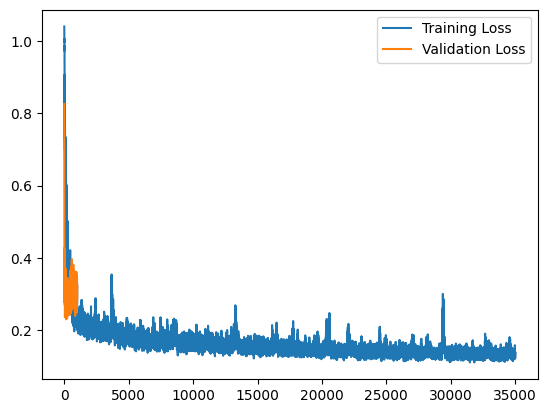

In [34]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()

In [37]:
%matplotlib inline
from torchdiffeq import odeint

all_data = torch.from_numpy(time_delayed_data[:, :timesteps_per_sample, :]).float().to(device)
new_data_size = 150
dt = np.diff(samp_ts.cpu())[0]

new_ts = np.arange(0, new_data_size*dt, step=dt)
new_ts = torch.from_numpy(new_ts).float().to(device)

h = torch.zeros(1, data.shape[0], rnn_hidden).to(device)
c = torch.zeros(1, data.shape[0], rnn_hidden).to(device)

hn = h[0, :, :]
cn = c[0, :, :]

for t in reversed(range(all_data.shape[1])):
    obs = all_data[:, t, :]
    out, hn, cn = rec.forward(obs, hn, cn)
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
epsilon = torch.randn(qz0_mean.size()).to(device)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

# forward in time and solve ode for reconstructions
pred_z = odeint(func, z0, new_ts).permute(1, 0, 2) #change time and batch with permute
pred_x = dec(pred_z)

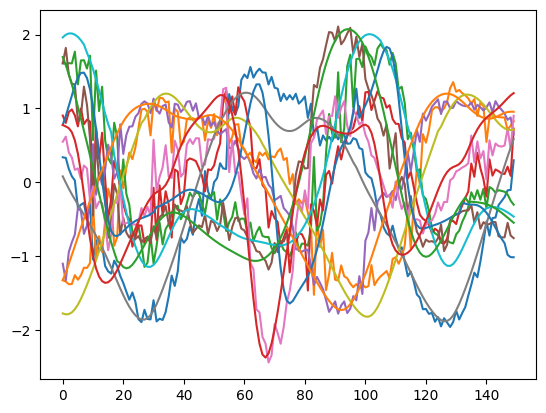

In [40]:
plt.plot(pred_x[10, :, ::k].detach().cpu())
plt.plot(time_delayed_data[10, :timesteps_per_sample, ::k])

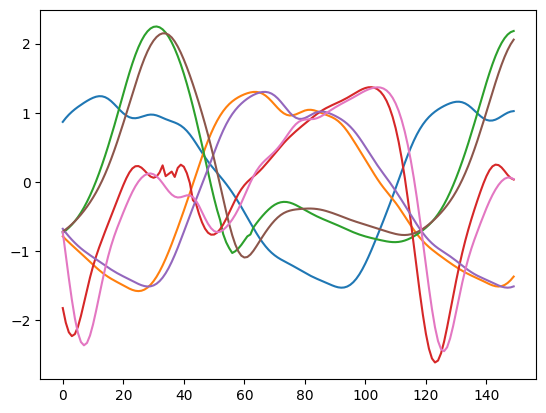

In [26]:
plt.plot(time_delayed_data[0, :timesteps_per_sample, ::k])
plt.show()

In [ ]:
metrics = model.evaluate()

## Get self-driven data

In [ ]:
self_generated_data = ddfa_node.generate_data_from_model(model, steps=5000)

## Estimate Floquet multipliers

In [ ]:
λs = ddfa_node.get_FM(self_generated_data)

## Visualize Floquet multipliers

In [ ]:
ddfa_node.make_FM_plots(λs)